In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import csv

## Reading

In [3]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 150

In [4]:
row_start = 14

In [5]:
metadata = dict()
filename = "2B.CSV"
with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for (i, row) in enumerate(reader):
        if i > row_start: break
        if len(row) >= 2: metadata[row[0]] = row[1]
metadata

{'Model': 'MSO2024B',
 'Firmware Version': '1.56',
 'Point Format': 'Y',
 'Horizontal Units': 'S',
 'Horizontal Scale': '0.001',
 'Sample Interval': '8e-08',
 'Filter Frequency': '2e+08',
 'Record Length': '125000',
 'Gating': '0.0% to 100.0%',
 'Probe Attenuation': '1',
 'Vertical Units': 'V',
 'Vertical Offset': '0',
 'Vertical Scale': '2',
 'Label': ''}

In [6]:
data = pd.read_csv(filename, delimiter=",", header=row_start)
data

,TIME,CH1,CH1 Peak Detect,CH2,CH2 Peak Detect
0,-0.00078,-7.152560e-09,-7.152560e-09,-5.364420e-09,8.000000e-02
1,-0.00078,-8.000000e-02,-8.000000e-02,8.000000e-02,-8.000000e-02
2,-0.00078,-8.000000e-02,-7.152560e-09,8.000000e-02,8.000000e-02
3,-0.00078,-8.000000e-02,-8.000000e-02,8.000000e-02,-5.364420e-09
4,-0.00078,-8.000000e-02,-7.152560e-09,-5.364420e-09,8.000000e-02
...,...,...,...,...,...
124995,0.00922,4.000000e+00,3.840000e+00,8.000000e-02,-8.000000e-02
124996,0.00922,3.920000e+00,4.000000e+00,-5.364420e-09,8.000000e-02
124997,0.00922,3.840000e+00,3.840000e+00,8.000000e-02,-8.000000e-02
124998,0.00922,3.920000e+00,4.000000e+00,8.000000e-02,8.000000e-02


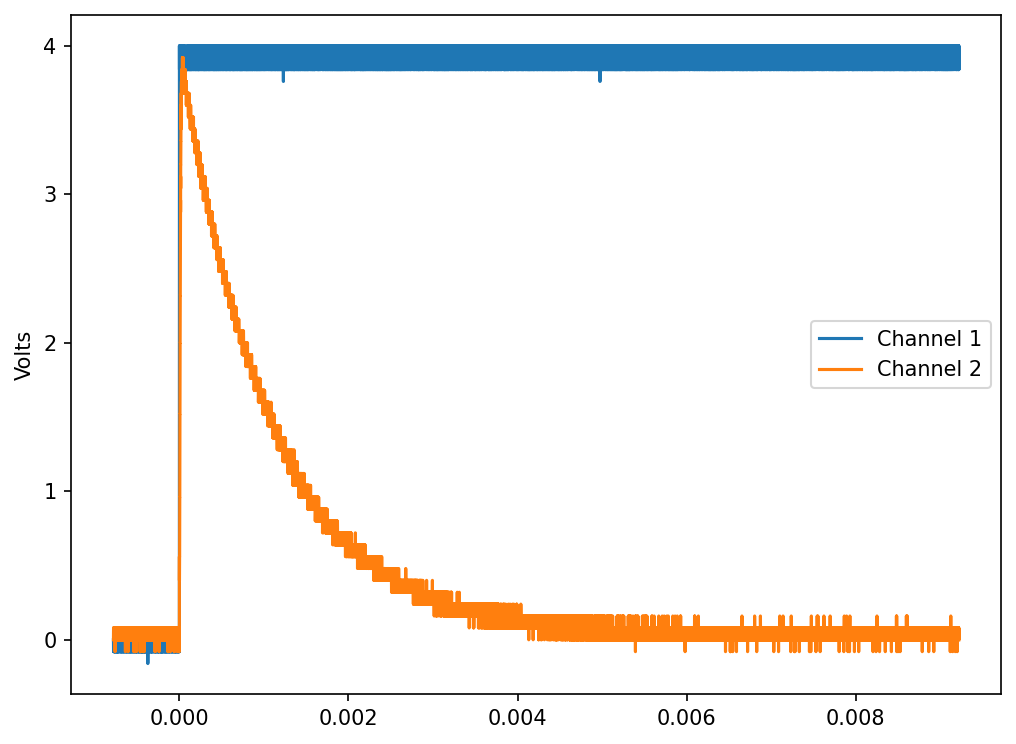

In [7]:
t_raw = data["TIME"].to_numpy()
ch1_raw = data["CH1"].to_numpy()
ch2_raw = data["CH2"].to_numpy()
plt.plot(
    t_raw, 
    ch1_raw,
    label="Channel 1"
)
plt.plot(
    t_raw, 
    ch2_raw,
    label="Channel 2"
)
plt.ylabel("Volts")
plt.legend()

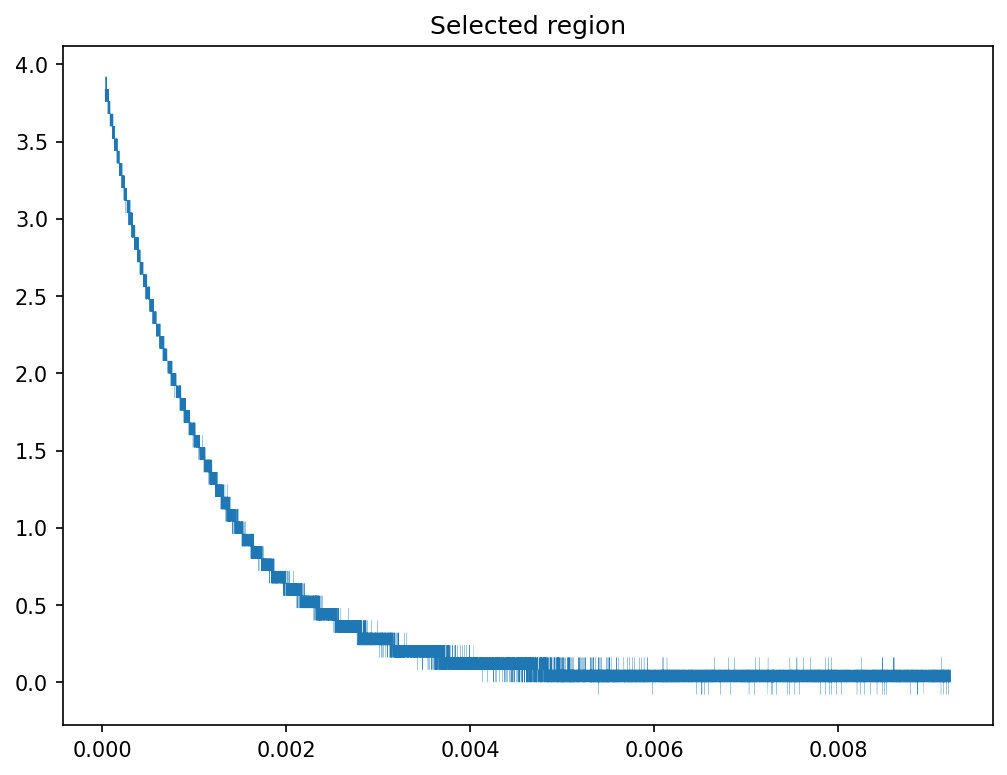

In [8]:
t = t_raw[ch1_raw > 3.5][350:]
ch2_noisy = ch2_raw[ch1_raw > 3.5][350:]
plt.plot(t, ch2_noisy, lw=0.1)
plt.title("Selected region")
plt.show()

In [9]:
np.diff(ch2_noisy)

array([-0.08      ,  0.        ,  0.08      , ...,  0.08000001,
        0.        , -0.08000001])

In [10]:
from scipy import signal

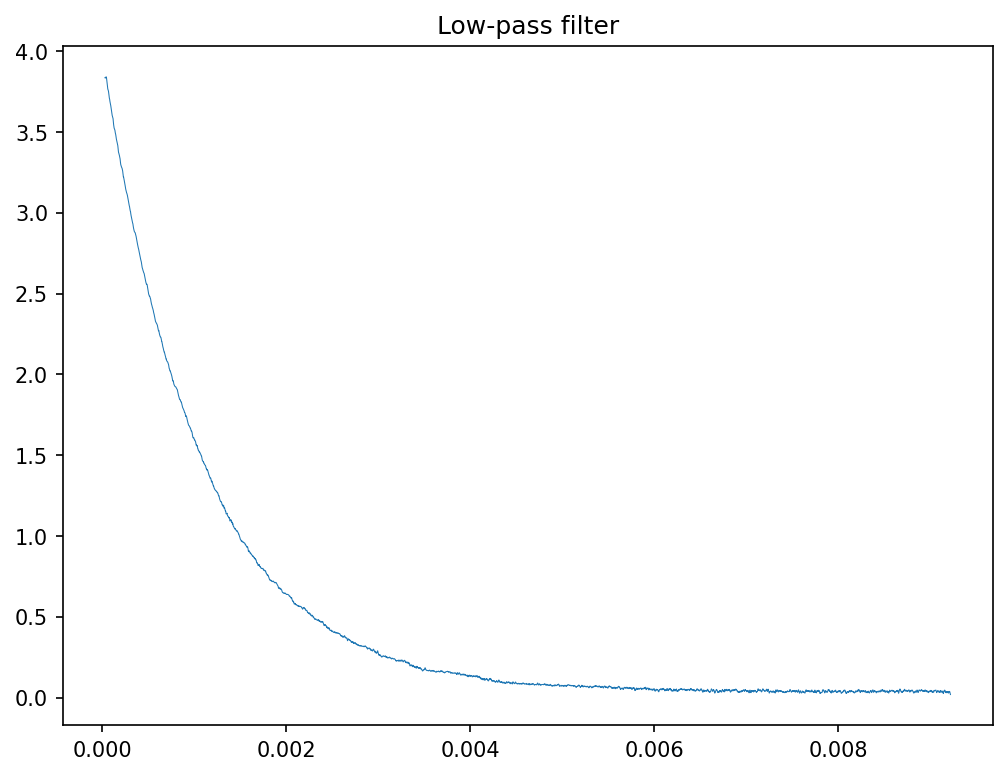

In [11]:
sample_frequency = 2e8
cutoff_frequency = 1e6
b, a = signal.butter(1, 2*cutoff_frequency/sample_frequency)
ch2 = signal.filtfilt(b, a, ch2_noisy)
plt.plot(t, ch2, lw=0.5)
plt.title("Low-pass filter")
plt.show()

## Modeling

In [12]:
model = lambda t, A, alpha, b: A * np.exp(-alpha*t) + b
[A_model, alpha_model, b_model], cov = (
    sp.optimize.curve_fit(model, t, ch2)
)
A_model, alpha_model, b_model, cov

(3.954479524028815,
 938.3554936624205,
 0.03576270632696684,
 array([[1.80839471e-08, 4.36969183e-06, 8.88699394e-11],
        [4.36969183e-06, 2.75830692e-03, 8.51590588e-07],
        [8.88699394e-11, 8.51590588e-07, 8.76771758e-10]]))

In [13]:
[dA_model, dAlpha_model, dB_model] = np.sqrt(cov.diagonal())
dA_model, dAlpha_model, dB_model

(0.00013447656708762072, 0.052519586068171004, 2.9610331954686608e-05)

In [14]:
v_model = model(t, A_model, alpha_model, b_model)
res = ch2 - v_model

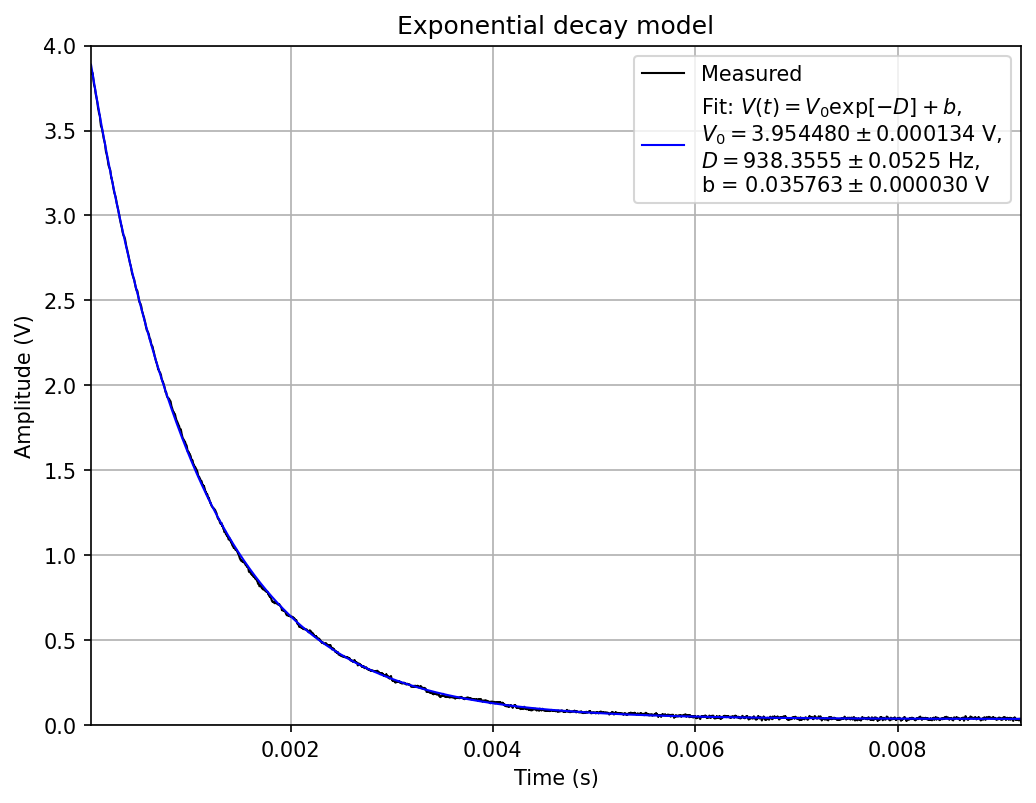

In [15]:
fit_label = "\n".join([
    r"Fit: $V(t) = V_0 \exp[-D] + b$,",
    f"$V_0 = {A_model:.6f} \pm {dA_model:.6f}$ V,",
    f"$D = {alpha_model:.4f} \pm {dAlpha_model:.4f}$ Hz,",
    f"b = ${b_model:.6f} \pm {dB_model:.6f}$ V",
])
plt.title("Exponential decay model")
plt.plot(t, ch2, lw=1, color="black", label="Measured")
plt.plot(t, v_model, lw=1, color="blue", label=fit_label)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.margins(0)
plt.ylim(0,4)
plt.grid()
plt.legend()
plt.show()

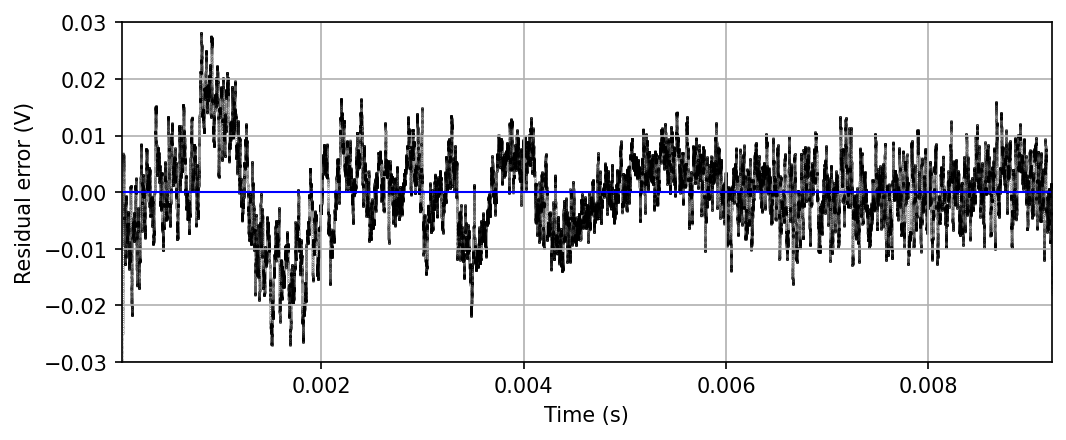

In [18]:
plt.rcParams['figure.figsize'] = [8, 3]
plt.scatter(t, res, s=0.01, color="black")
plt.axhline(0, lw=1, color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Residual error (V)")
plt.margins(0, 0.1)
plt.ylim(-0.03, +0.03)
plt.grid()
plt.show()

In [26]:
dof = 3
dRes = np.mean(np.abs(np.diff(ch2_noisy)))
chi2 = np.sum( ((ch2_noisy - v_model)/dRes)**2 )
chi2_reduced = chi2 / ( len(res) - dof )
chi2_reduced

1.4214952798905347